In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


.\customer-churn-table.csv.csv
.\dev.ipynb


In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap

import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\hitma\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('./customer-churn-table.csv.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
display(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
df[['tenure', 'MonthlyCharges', 'TotalCharges']].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


In [7]:
# Encode Categorical Features
categorical_features = ["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]
label_features = ["InternetService", "Contract", "PaymentMethod"]
phoneServiceDependent = ["MultipleLines"]
internetServiceDependent = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

In [8]:
for feature in label_features:
    display(df[feature].value_counts())

InternetService
Fiber optic    3096
DSL            2416
No             1520
Name: count, dtype: int64

Contract
Month-to-month    3875
Two year          1685
One year          1472
Name: count, dtype: int64

PaymentMethod
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: count, dtype: int64

In [9]:
# Scale Tenure, Monthly Charges, and Total Charges
df['tenure_sqrt'] = np.sqrt(df['tenure'])
df['MonthlyCharges_sqrt'] = np.sqrt(df['MonthlyCharges'])
df['TotalCharges_sqrt'] = df['tenure_sqrt'] * df['MonthlyCharges_sqrt']

# Label Encode Features
le = LabelEncoder()
for feature in label_features:
    label = feature
    df[label] = le.fit_transform(df[feature])

df[categorical_features] = df[categorical_features].replace({'Yes': 1, 'No': 0})
df["MultipleLines"] = df["MultipleLines"].replace({"No phone service": -1, "No": 0, "Yes": 1})
df["gender"] = df["gender"].replace({"Female": 2, "Male": 1})
for feature in internetServiceDependent:
    df[feature] = df[feature].replace({"No": 0, "Yes": 1, "No internet service": -1})

features_drop = ['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']
df_transformed = df.drop(columns=features_drop, axis=1)
df_transformed.head(15)

C:\Users\hitma\AppData\Local\Temp\ipykernel_21668\1885794381.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[categorical_features] = df[categorical_features].replace({'Yes': 1, 'No': 0})
C:\Users\hitma\AppData\Local\Temp\ipykernel_21668\1885794381.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["MultipleLines"] = df["MultipleLines"].replace({"No phone service": -1, "No": 0, "Yes": 1})
C:\Users\hitma\AppData\Local\Temp\ipykernel_21668\1885794381.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated a

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,tenure_sqrt,MonthlyCharges_sqrt,TotalCharges_sqrt
0,2,0,1,0,0,-1,0,0,1,0,0,0,0,0,1,2,0,1.000000,5.463515,5.463515
1,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,3,0,5.830952,7.546522,44.003409
2,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,3,1,1.414214,7.338256,10.377861
3,1,0,0,0,0,-1,0,1,0,1,1,0,0,1,0,0,0,6.708204,6.503845,43.629119
4,2,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1,1.414214,8.408329,11.891173
5,2,0,0,0,1,1,1,0,0,1,0,1,1,0,1,2,1,2.828427,9.982485,28.234730
6,1,0,0,1,1,1,1,0,1,0,0,1,0,0,1,1,0,4.690416,9.439280,44.274146
7,2,0,0,0,0,-1,0,1,0,0,0,0,0,0,0,3,0,3.162278,5.454356,17.248188
8,2,0,1,0,1,1,1,0,0,1,1,1,1,0,1,2,1,5.291503,10.237187,54.170102
9,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,7.874008,7.493330,59.002542


In [10]:
df_transformed["MultipleLines"] = df_transformed["MultipleLines"] * df_transformed["PhoneService"]
df_transformed[["PhoneService", "MultipleLines"]].head(10)

,PhoneService,MultipleLines
0,0,0
1,1,0
2,1,0
3,0,0
4,1,0
5,1,1
6,1,1
7,0,0
8,1,1
9,1,0


In [11]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               7032 non-null   int64  
 1   SeniorCitizen        7032 non-null   int64  
 2   Partner              7032 non-null   int64  
 3   Dependents           7032 non-null   int64  
 4   PhoneService         7032 non-null   int64  
 5   MultipleLines        7032 non-null   int64  
 6   InternetService      7032 non-null   int32  
 7   OnlineSecurity       7032 non-null   int64  
 8   OnlineBackup         7032 non-null   int64  
 9   DeviceProtection     7032 non-null   int64  
 10  TechSupport          7032 non-null   int64  
 11  StreamingTV          7032 non-null   int64  
 12  StreamingMovies      7032 non-null   int64  
 13  Contract             7032 non-null   int32  
 14  PaperlessBilling     7032 non-null   int64  
 15  PaymentMethod        7032 non-null   int32 

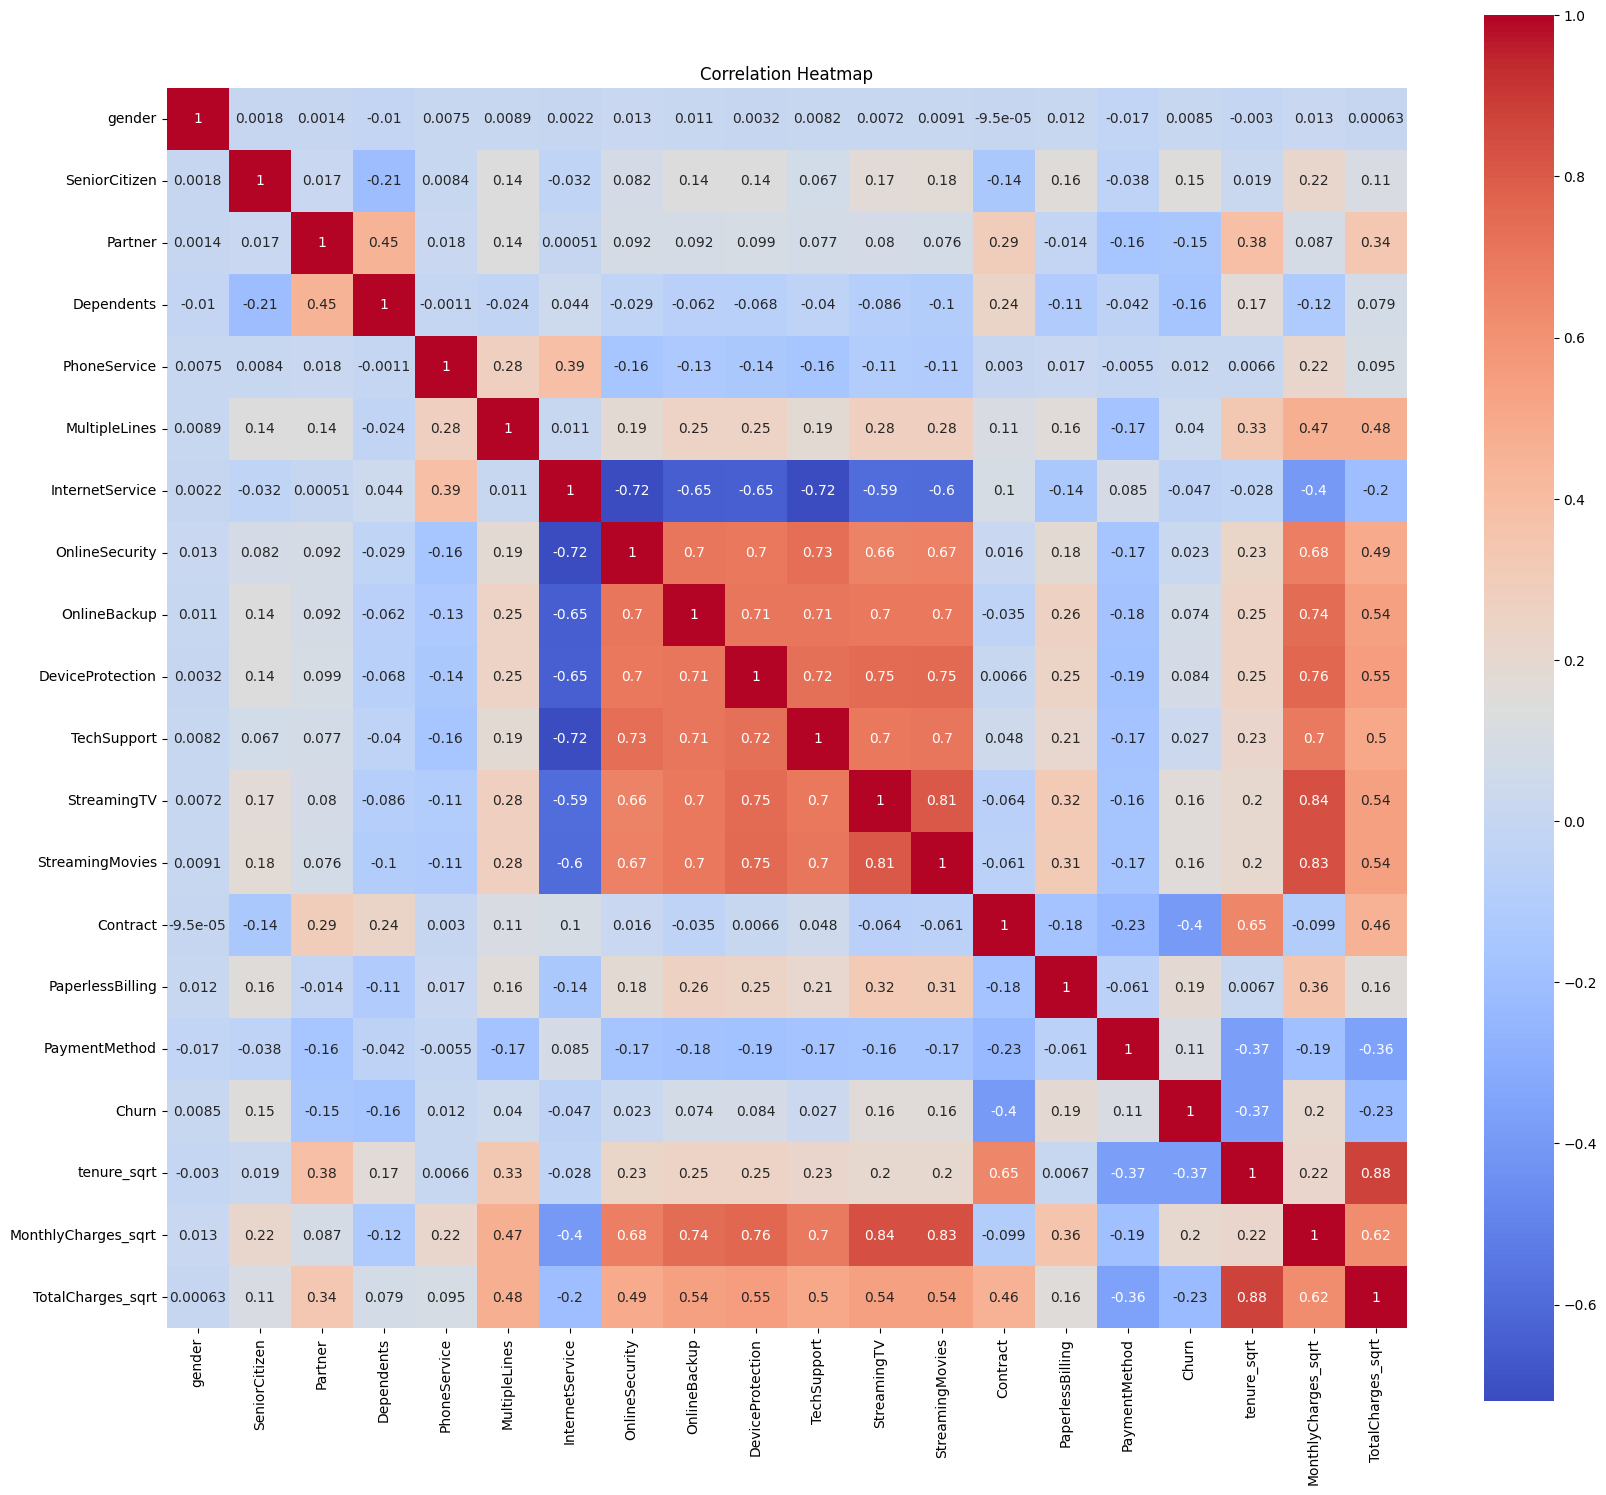

In [12]:
corr_matrix = df_transformed.corr()
plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

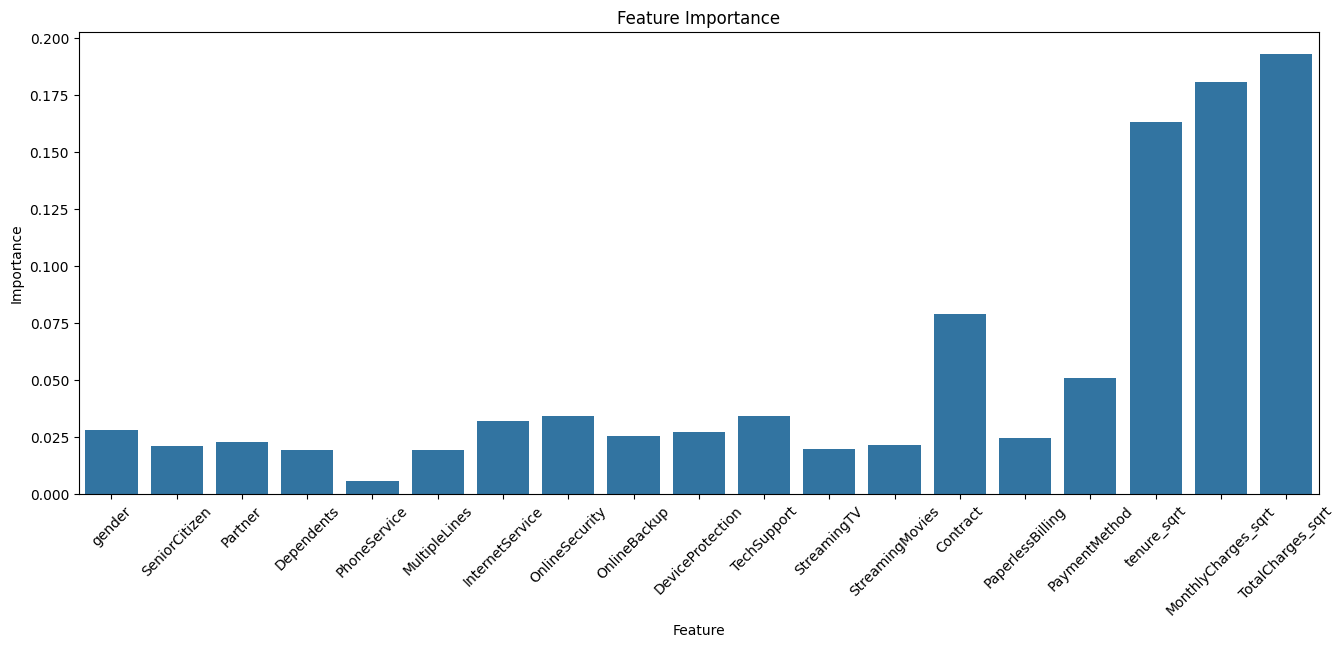

In [16]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df_transformed.drop('Churn', axis=1), df_transformed['Churn'])

feature_importances = rf.feature_importances_
feature_names = df_transformed.drop('Churn', axis=1).columns

plt.figure(figsize=(16, 6))
sns.barplot(x=feature_names, y=feature_importances)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.ylabel('Importance')
plt.show()

In [17]:
corr_matrix = df_transformed.corr()
churn_correlations = corr_matrix['Churn'].abs().sort_values(ascending=False)
display("Absolute Correlations with Churn:")
display(churn_correlations)

'Absolute Correlations with Churn:'

Churn                  1.000000
Contract               0.396150
tenure_sqrt            0.372940
TotalCharges_sqrt      0.225157
MonthlyCharges_sqrt    0.202913
PaperlessBilling       0.191454
StreamingTV            0.164509
Dependents             0.163128
StreamingMovies        0.162672
SeniorCitizen          0.150541
Partner                0.149982
PaymentMethod          0.107852
DeviceProtection       0.084402
OnlineBackup           0.073934
InternetService        0.047097
MultipleLines          0.040033
TechSupport            0.026744
OnlineSecurity         0.023014
PhoneService           0.011691
gender                 0.008545
Name: Churn, dtype: float64

In [18]:
drop_redundant = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "PhoneService", "MultipleLines", "PaperlessBilling", "gender"]
df_feature_selection = df_transformed.drop(columns=drop_redundant, axis=1)
df_feature_selection.head(10)

,SeniorCitizen,Partner,Dependents,InternetService,Contract,PaymentMethod,Churn,tenure_sqrt,MonthlyCharges_sqrt,TotalCharges_sqrt
0,0,1,0,0,0,2,0,1.000000,5.463515,5.463515
1,0,0,0,0,1,3,0,5.830952,7.546522,44.003409
2,0,0,0,0,0,3,1,1.414214,7.338256,10.377861
3,0,0,0,0,1,0,0,6.708204,6.503845,43.629119
4,0,0,0,1,0,2,1,1.414214,8.408329,11.891173
5,0,0,0,1,0,2,1,2.828427,9.982485,28.234730
6,0,0,1,1,0,1,0,4.690416,9.439280,44.274146
7,0,0,0,0,0,3,0,3.162278,5.454356,17.248188
8,0,1,0,1,0,2,1,5.291503,10.237187,54.170102
9,0,0,1,0,1,0,0,7.874008,7.493330,59.002542


In [19]:
display(df_feature_selection["Churn"].value_counts())

Churn
0    5163
1    1869
Name: count, dtype: int64

In [20]:
# Define the features (X) and target (y)
X = df_feature_selection.drop('Churn', axis=1)
y = df_feature_selection['Churn']

# Create a SMOTE object
smote = SMOTE(random_state=42)

# Fit the SMOTE object to the data and transform it
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new dataframe with the resampled data
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Print the class distribution of the resampled data
print(df_resampled['Churn'].value_counts())

Churn
0    5163
1    5163
Name: count, dtype: int64


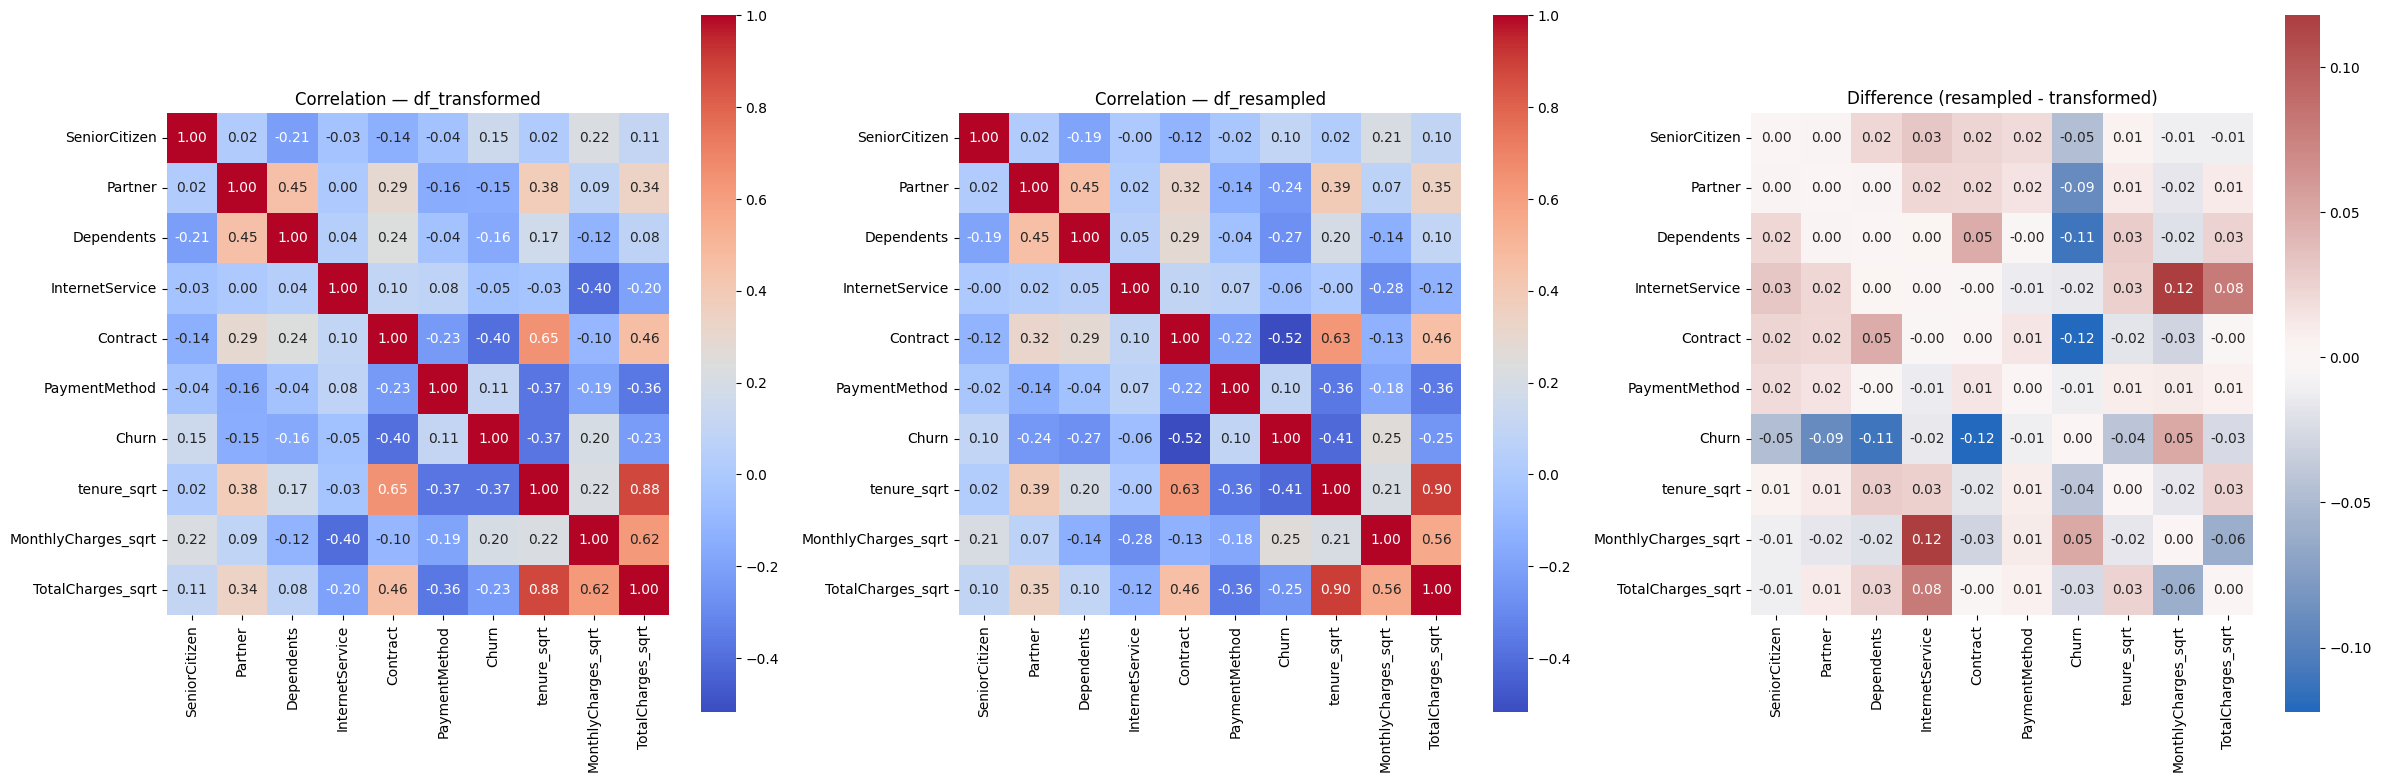

In [22]:
# compare correlations for common columns and plot side-by-side heatmaps + difference
common_cols = df_transformed.columns.intersection(df_resampled.columns)

corr_orig = df_transformed[common_cols].corr()
corr_res = df_resampled[common_cols].corr()

# ensure same scale for both heatmaps
vmin = min(corr_orig.min().min(), corr_res.min().min())
vmax = max(corr_orig.max().max(), corr_res.max().max())

diff = corr_res - corr_orig

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
sns.heatmap(corr_orig, ax=axes[0], vmin=vmin, vmax=vmax, cmap='coolwarm', annot=True, fmt='.2f', square=True)
axes[0].set_title('Correlation — df_transformed')

sns.heatmap(corr_res, ax=axes[1], vmin=vmin, vmax=vmax, cmap='coolwarm', annot=True, fmt='.2f', square=True)
axes[1].set_title('Correlation — df_resampled')

# difference uses a diverging center at 0
sns.heatmap(diff, ax=axes[2], center=0, cmap='vlag', annot=True, fmt='.2f', square=True)
axes[2].set_title('Difference (resampled - transformed)')

plt.tight_layout()
plt.show()

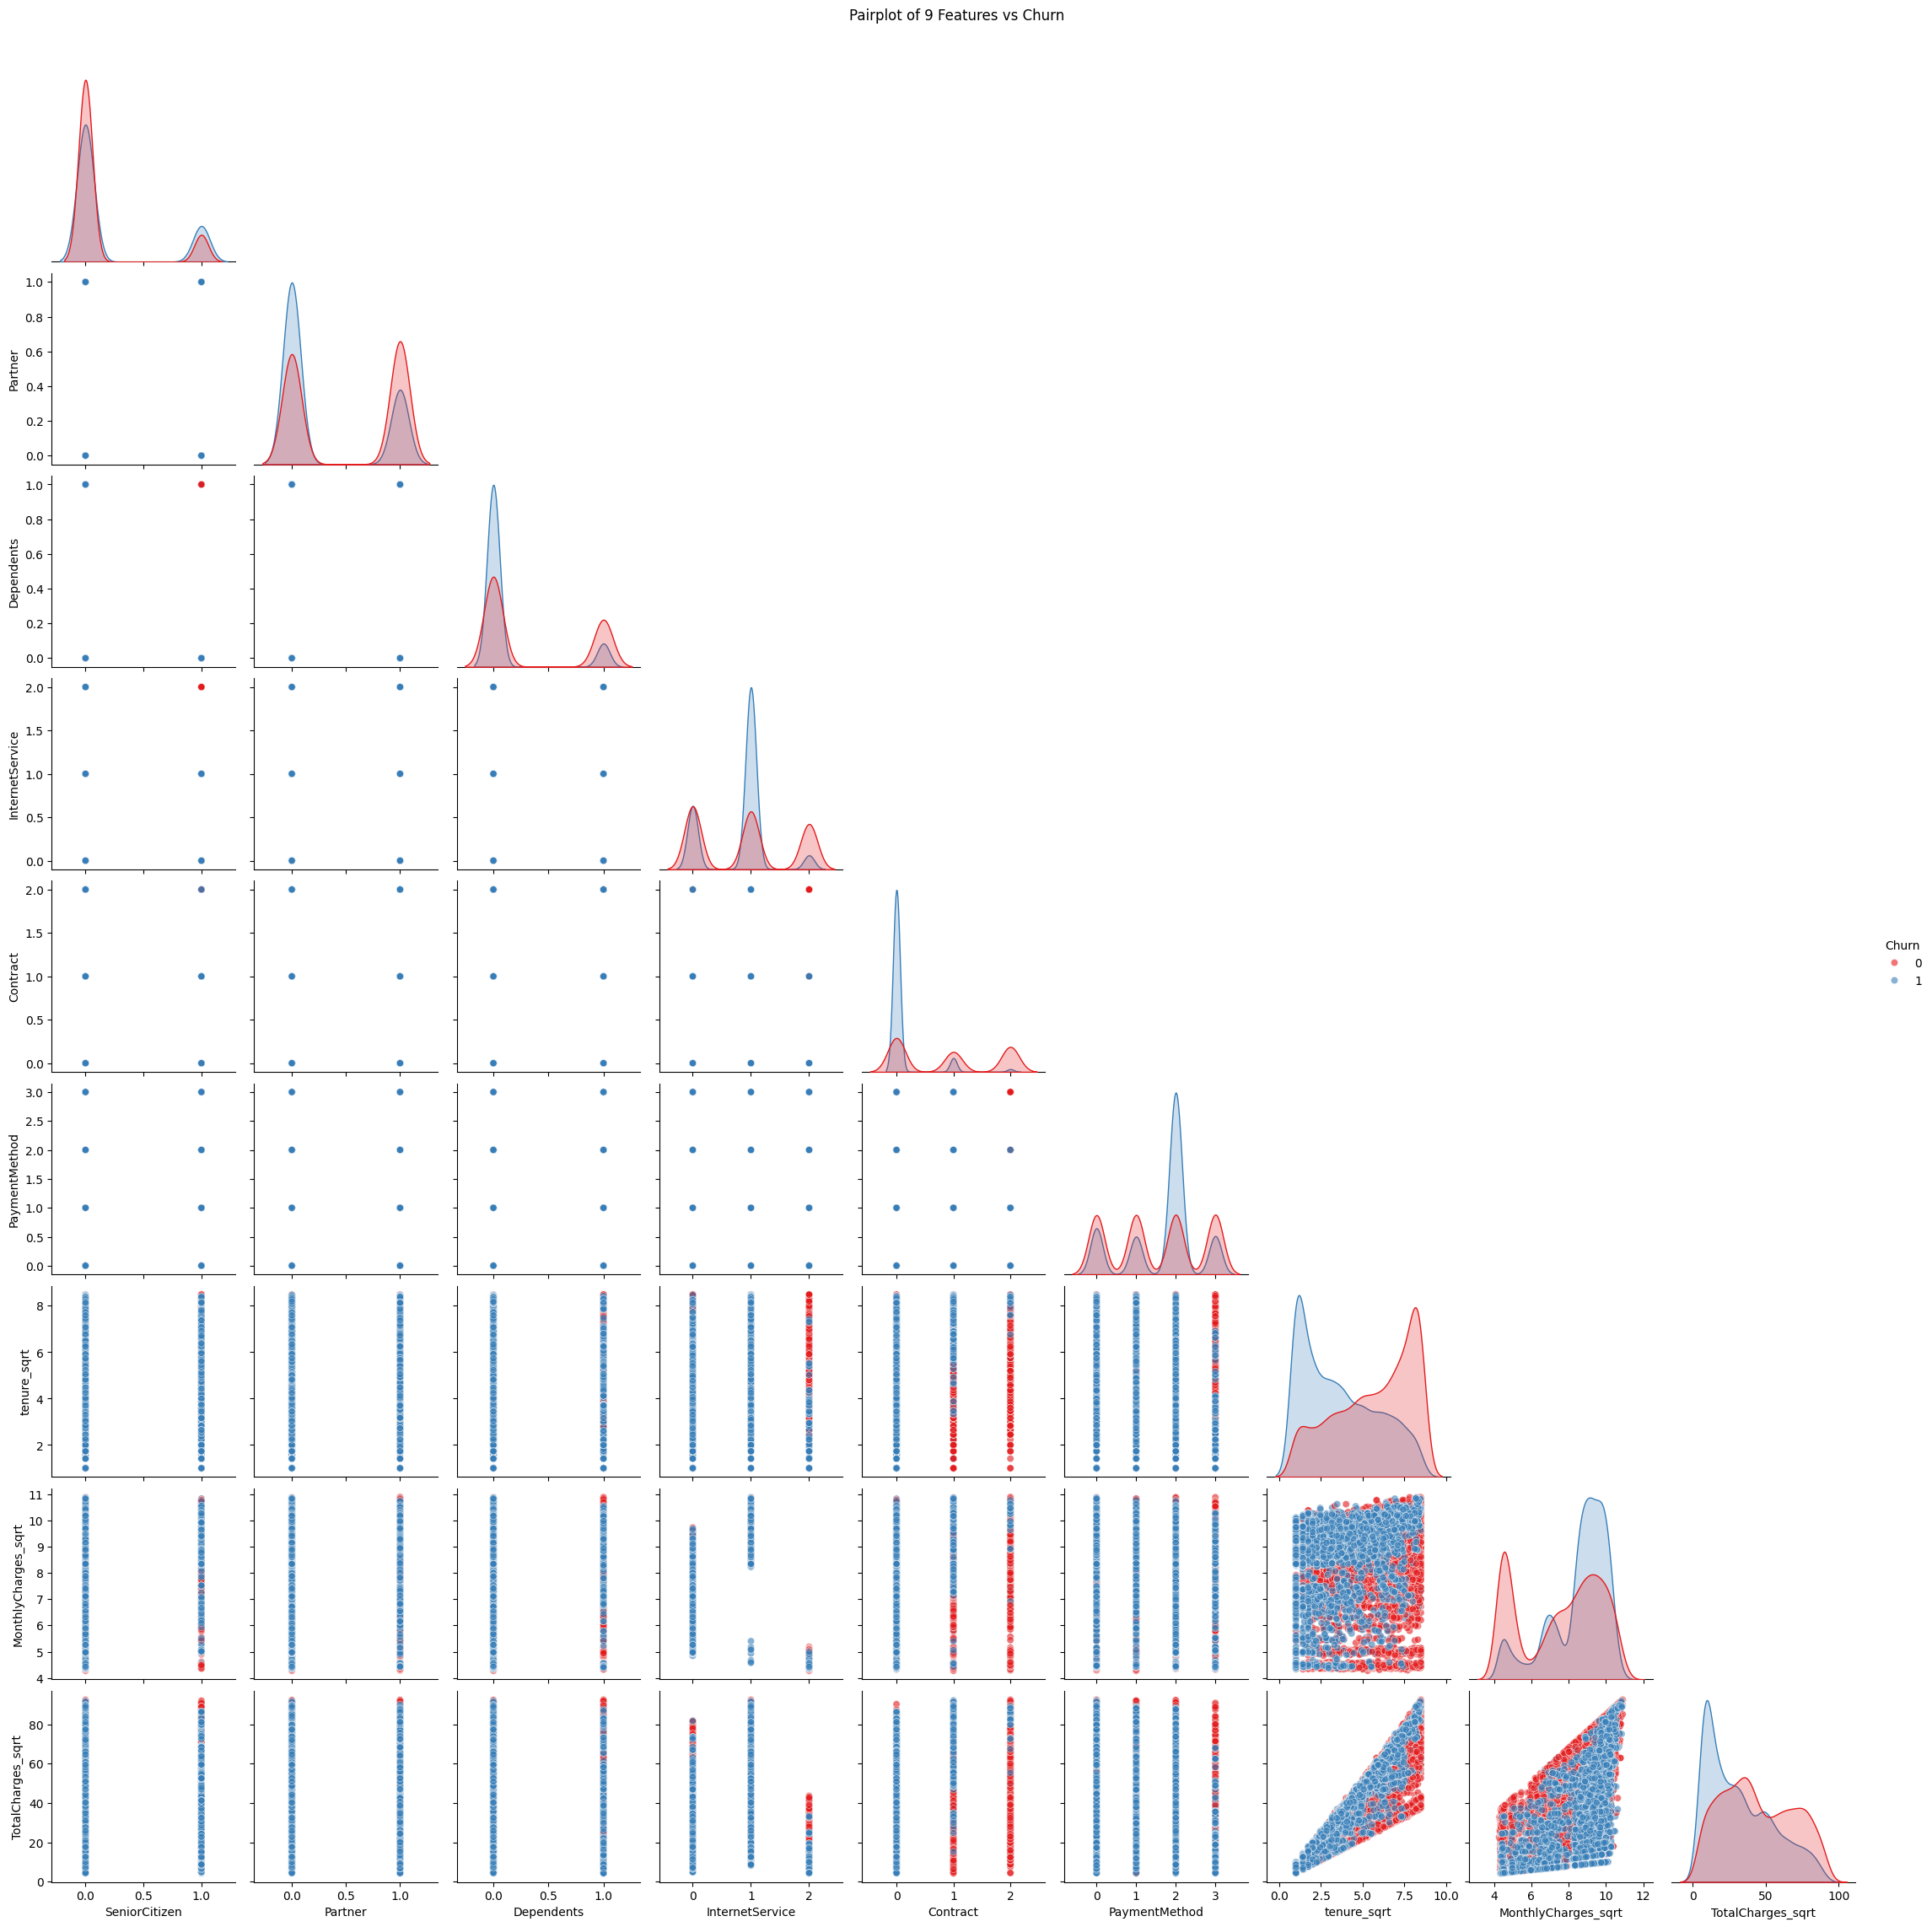

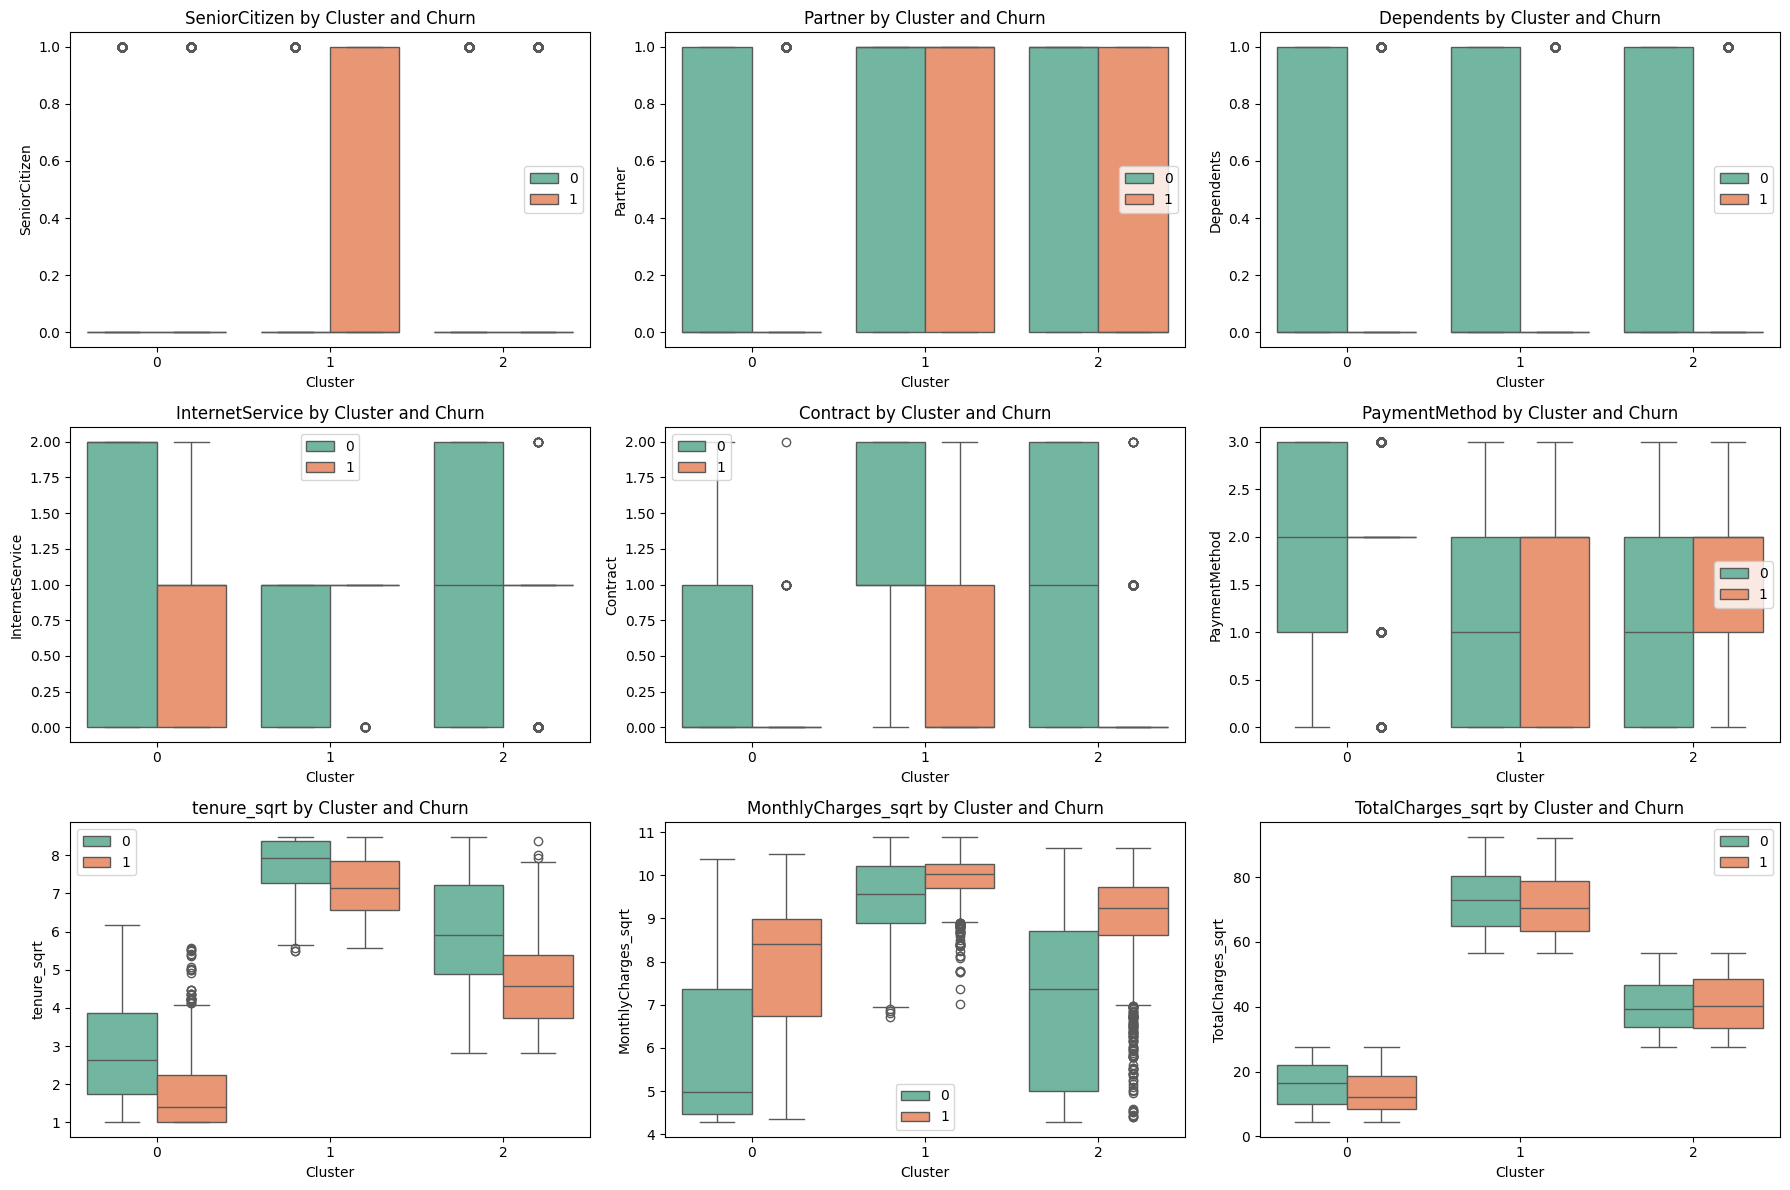

In [26]:
# KMeans clustering and feature visualization against Churn
# from sklearn.cluster import KMeans
# import seaborn as sns
# import matplotlib.pyplot as plt

# Select 9 features and Churn for visualization (update with your actual feature names)
features_to_plot = df_resampled.drop('Churn', axis=1).columns[:9].tolist()  # first 9 features
plot_df = df_resampled[features_to_plot + ['Churn']].copy()

# Fit KMeans
n_clusters = 3  # You can change this number as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
plot_df['Cluster'] = kmeans.fit_predict(plot_df[features_to_plot])

# Pairplot: features vs Churn, colored by cluster
sns.pairplot(plot_df, vars=features_to_plot, hue='Churn', palette='Set1', corner=True, diag_kind='kde', plot_kws={'alpha':0.6})
plt.suptitle('Pairplot of 9 Features vs Churn', y=1.02)
plt.show()

# Boxplot: feature distributions by cluster and Churn
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
for i, feature in enumerate(features_to_plot):
    ax = axes[i//3, i%3]
    sns.boxplot(x='Cluster', y=feature, hue='Churn', data=plot_df, ax=ax, palette='Set2')
    ax.set_title(f'{feature} by Cluster and Churn')
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [31]:
df_model_ready = df_resampled.drop(columns=['Dependents', 'Partner', 'TotalCharges_sqrt'], axis=1)
display(df_model_ready)

,SeniorCitizen,InternetService,Contract,PaymentMethod,tenure_sqrt,MonthlyCharges_sqrt,Churn
0,0,0,0,2,1.000000,5.463515,0
1,0,0,1,3,5.830952,7.546522,0
2,0,0,0,3,1.414214,7.338256,1
3,0,0,1,0,6.708204,6.503845,0
4,0,1,0,2,1.414214,8.408329,1
...,...,...,...,...,...,...,...
10321,0,1,1,0,7.587697,10.176789,1
10322,1,1,0,2,3.442950,9.423001,1
10323,0,2,0,3,2.236068,4.424519,1
10324,0,1,0,2,1.414214,8.929164,1


In [33]:
# Decision Tree model training and evaluation on df_model_ready

# Prepare features and target
X = df_model_ready.drop('Churn', axis=1)
y = df_model_ready['Churn']

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Predict and evaluate
y_pred = dt.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.750242013552759
Precision: 0.7459562321598477
Recall: 0.7589545014520813
F1 Score: 0.7523992322456814

Confusion Matrix:
[[766 267]
 [249 784]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      1033
           1       0.75      0.76      0.75      1033

    accuracy                           0.75      2066
   macro avg       0.75      0.75      0.75      2066
weighted avg       0.75      0.75      0.75      2066



In [44]:
# ==============================
# 1. Train-Test Split
# ==============================
X = df_model_ready.drop('Churn', axis=1)   # Assuming 'Churn' is your target column (binary: 0/1)
y = df_model_ready['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==============================
# 2. Define XGBoost Model
# ==============================
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

In [ ]:
# ==============================
# 3. Hyperparameter Search Space
# ==============================
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [1]  # Already balanced with SMOTE, keep 1
}

# ==============================
# 4. RandomizedSearchCV with Stratified K-Fold
# ==============================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring='f1',  # Focus on F1 for churn
    n_iter=50,     # Try 50 combinations
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit search
random_search.fit(X_train, y_train)

# Best Params
print("Best Parameters:", random_search.best_params_)

# ==============================
# 5. Evaluate on Test Set
# ==============================
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Precision-Recall AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall_curve, precision_curve)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


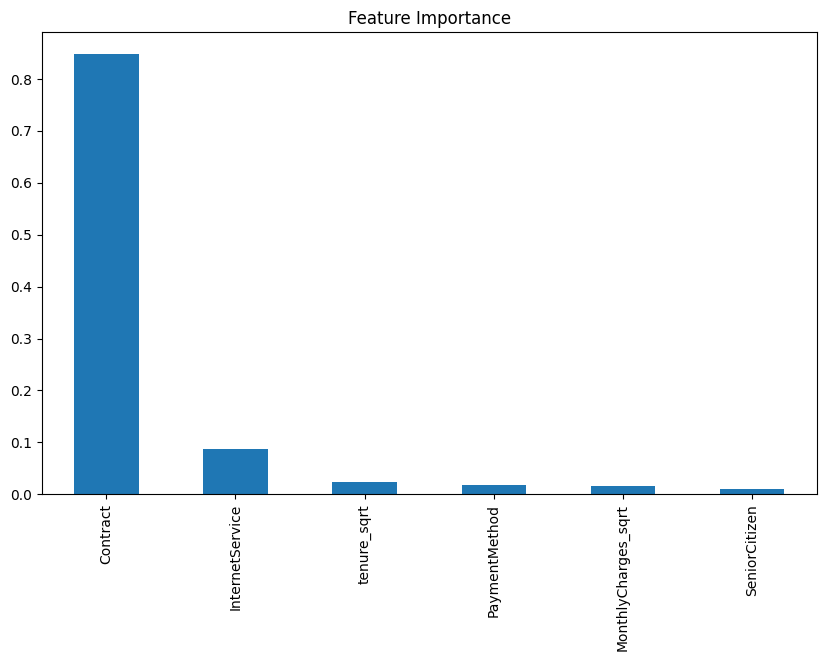

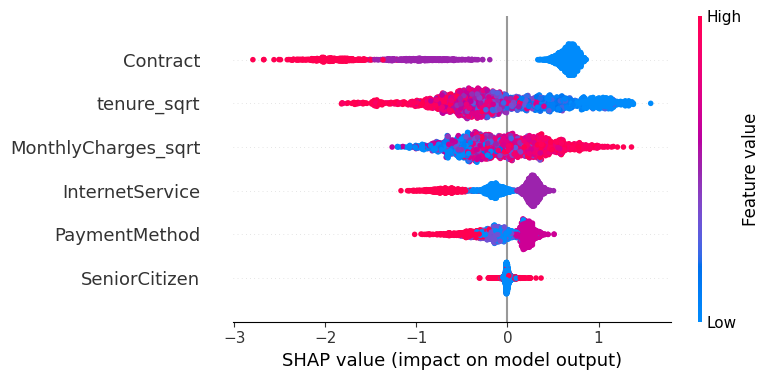

In [42]:
# ==============================
# 6. Feature Importance
# ==============================
plt.figure(figsize=(10, 6))
best_model.get_booster().get_score(importance_type='weight')
xgb_importance = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
xgb_importance.plot(kind='bar', title='Feature Importance')
plt.show()

# ==============================
# 7. SHAP for Explainability
# ==============================
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)